# Advanced Rice Grain Classification Using Convolutional Neural Networks in TensorFlow

## Business Understanding

### Abstract

Rice has many genetic varieties and one of the most produced grain worldwide. These varieties are differentiated from each other by some of their features which include, shape, colour and texture.These features will enable to distinguish, classify and evaluate the quality of seeds. In this study, Arborio, Ipsala, Jasmine, Karcadag and Basmati are the five varieties found and grown in Turkey that will be used.The primary objective of this project is to develop a convolutional neural network (CNN) model that can accurately classify different types of rice grains from the images. This problem addresses the need for automated quality control in the agriculture and food processing industries. With the rapid advancements in technology, there is a growing demand for efficient and accurate methods to classify agricultural products. Traditional methods are labour-intensive, time-consuming, and prone to human error. By leveraging CNNs, this project aims to automate the classification process, enhancing both efficiency and accuracy.

### Motivation

Ensuring the quality and type of rice is crucial for both farmers and consumers. High-quality rice ensures consumer satisfaction and adherence to market standards. Automating the classification process can significantly reduce labor costs and increase efficiency and accuracy. This topic is important for enhancing food security and quality control in the agricultural domain. Automated classification systems can also assist in identifying potential quality issues early in the supply chain, preventing large-scale distribution of substandard products.

### Industry/Application Domain

This project is applicable to the agriculture and food processing industries, specifically in the domain of quality control and inventory management. Accurate classification of rice types is essential for pricing, packaging, and distribution. Food processing companies can benefit from automated systems that ensure consistent quality and reduce the likelihood of human error. Additionally, such systems can be integrated into existing quality control processes, providing real-time feedback and analysis.

### Target Audience

The primary audience includes agricultural scientists, food processing companies, quality control personnel, and researchers in the field of computer vision and machine learning. Agricultural policymakers and educators can also benefit from understanding the impact of advanced technologies in improving agricultural practices.

### Data Collection

The dataset is obtained from Kaggle website
https://www.kaggle.com/code/karladriandeguzman/99-9-rice-image-classification-using-cnn-in-tf/notebook.
It contains five rice varieties with 75,000 images.

### Data Processing

**Importing Libraries**

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
import datetime

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


**Loading and Exploring data Set**

**Data Loading**

In [ ]:
dataset_path = r"C:/Users/bmaruru/Downloads/rice_data/Rice_Image_Dataset"


**Exploring directory structure**

In [ ]:
categories = os.listdir(dataset_path)
print(categories)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


**image count for each category**

In [ ]:
category_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
print(category_counts)


{'Arborio': 15000, 'Basmati': 15000, 'Ipsala': 15000, 'Jasmine': 15000, 'Karacadag': 15000}


**Visualizing Category Distribution**

C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

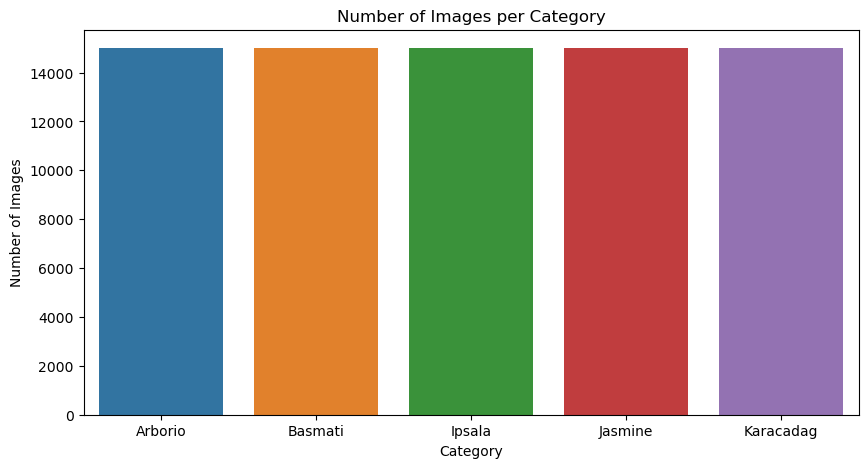

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


**Visualize Sample Images**


**Visualize Random Images from Each Category**

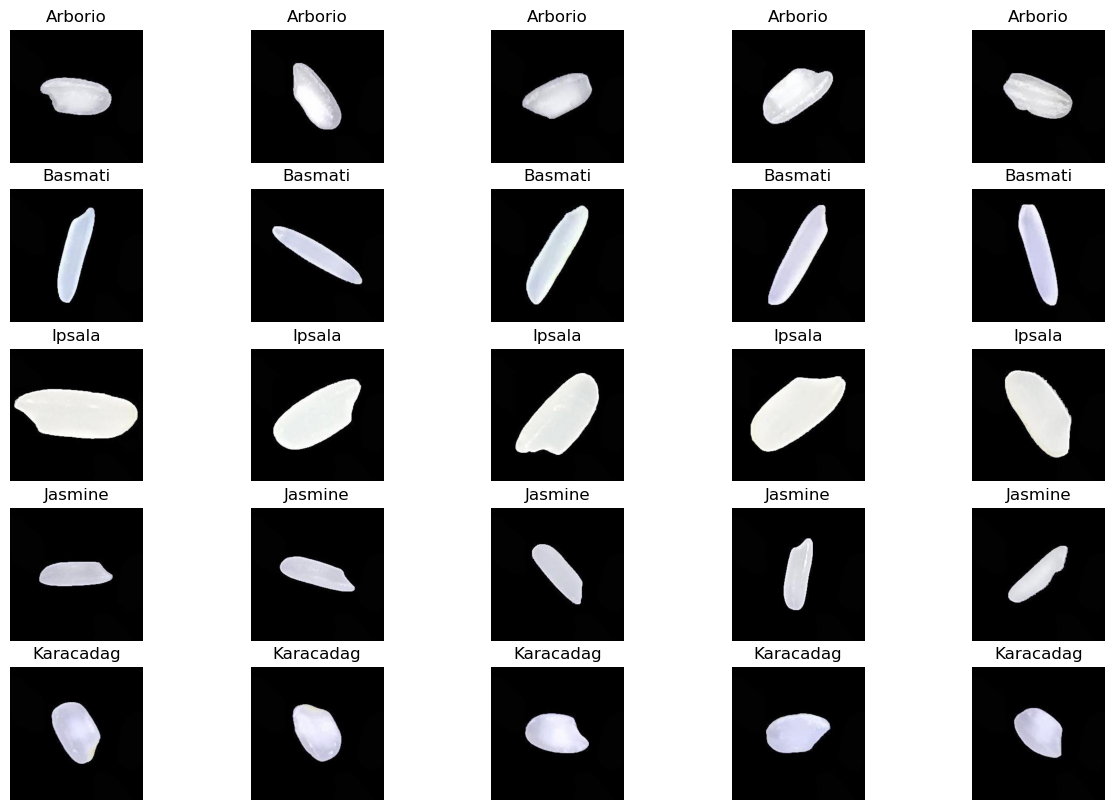

In [ ]:
def visualize_sample_images(dataset_path, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)
        for j in range(num_images):
            img = Image.open(os.path.join(category_path, images[j]))
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.show()

visualize_sample_images(dataset_path, categories)


**Analyze Image Properties**

In [ ]:
#Loading a sample of the images

def load_images(dataset_path, categories, num_images=100):
    data = []
    labels = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_images]
        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data.append(img)
            labels.append(category)
    return np.array(data), np.array(labels)

data, labels = load_images(dataset_path, categories)

**Analyze image Dimensions**

In [ ]:
image_shapes = [img.shape for img in data]
df_shapes = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels'])
print(df_shapes.describe())


       Height  Width  Channels
count   500.0  500.0     500.0
mean    250.0  250.0       3.0
std       0.0    0.0       0.0
min     250.0  250.0       3.0
25%     250.0  250.0       3.0
50%     250.0  250.0       3.0
75%     250.0  250.0       3.0
max     250.0  250.0       3.0


**Visualizing image Dimensions**

C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

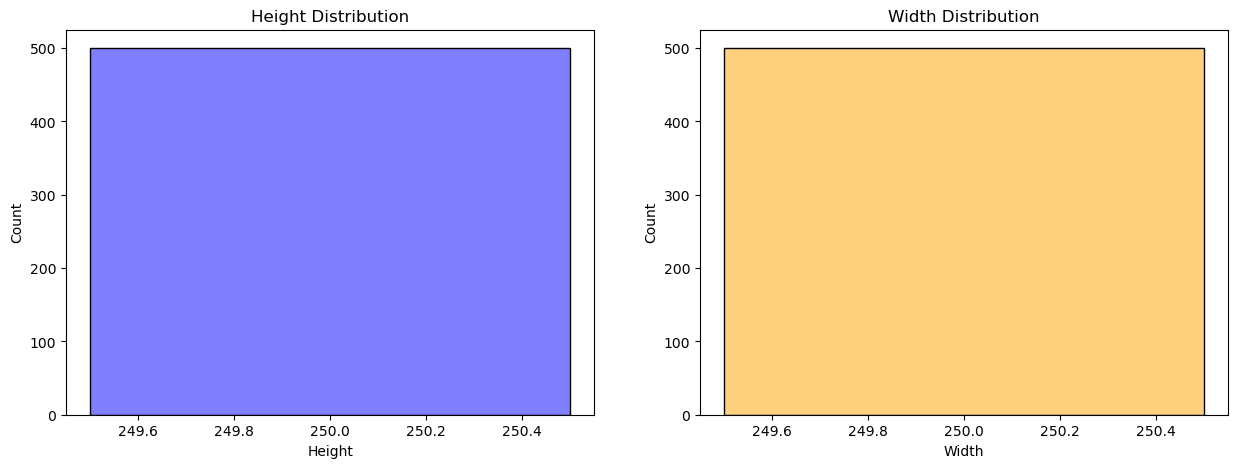

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_shapes['Height'], kde=True, ax=axs[0], color='blue')
axs[0].set_title('Height Distribution')

sns.histplot(df_shapes['Width'], kde=True, ax=axs[1], color='orange')
axs[1].set_title('Width Distribution')

plt.show()


In [ ]:
# Generate the features and store them in a csv file.
# def calculate_features(image):
#     features = {}
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Basic shape features
#     labeled_img = measure.label(gray_image > 0)
#     region_props = measure.regionprops(labeled_img)

#     if region_props:
#         region = region_props[0]
#         features['AREA'] = region.area
#         features['PERIMETER'] = region.perimeter
#         features['MAJOR_AXIS'] = region.major_axis_length
#         features['MINOR_AXIS'] = region.minor_axis_length
#         features['ECCENTRICITY'] = region.eccentricity
#         features['EQDIASQ'] = np.sqrt(4 * region.area / np.pi)
#         features['SOLIDITY'] = region.solidity
#         features['CONVEX_AREA'] = region.convex_area
#         features['EXTENT'] = region.extent
#         features['ASPECT_RATIO'] = region.major_axis_length / region.minor_axis_length if region.minor_axis_length != 0 else 0
#         features['ROUNDNESS'] = 4 * np.pi * region.area / (region.perimeter ** 2) if region.perimeter != 0 else 0
#         features['COMPACTNESS'] = region.area / (region.perimeter ** 2) if region.perimeter != 0 else 0

#     # Color features
#     for color_space, conversion in [('RGB', cv2.COLOR_BGR2RGB), ('HSV', cv2.COLOR_BGR2HSV), ('LAB', cv2.COLOR_BGR2LAB)]:
#         img_conv = cv2.cvtColor(image, conversion)
#         for i, col in enumerate(['R', 'G', 'B'] if color_space == 'RGB' else ['H', 'S', 'V'] if color_space == 'HSV' else ['L', 'A', 'B']):
#             channel = img_conv[:, :, i].flatten()
#             features[f'mean{color_space}{col}'] = np.mean(channel)
#             features[f'StdDev{color_space}{col}'] = np.std(channel)
#             features[f'skew{color_space}{col}'] = skew(channel)
#             features[f'kurtosis{color_space}{col}'] = kurtosis(channel)
#             features[f'entropy{color_space}{col}'] = entropy(channel)

#     return features

# # Calculate features for all images
# features_list = []
# for image in images:
#     features = calculate_features(image)
#     features_list.append(features)

# # Create DataFrame
# df = pd.DataFrame(features_list)
# df['CLASS'] = labels

# df.to_csv("image_features.csv", index=False)


In [ ]:
df = pd.read_csv('image_features.csv')

In [ ]:
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,StdDevLABA,skewLABA,kurtosisLABA,entropyLABA,meanLABB,StdDevLABB,skewLABB,kurtosisLABB,entropyLABB,CLASS
0,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,0.522094,3.101069,10.814786,10.823284,127.535375,1.255482,-2.696587,6.604742,10.823243,Arborio
1,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,0.604705,3.555362,12.482332,10.823281,127.631936,1.192312,-3.345385,10.772596,10.823248,Arborio
2,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,0.512400,3.141947,10.979176,10.823284,127.534977,1.277571,-2.776617,7.012515,10.823241,Arborio
3,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,0.364591,3.921327,24.819174,10.823288,127.707908,0.842688,-3.390172,12.617285,10.823270,Arborio
4,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,0.258704,5.828338,48.568412,10.823290,127.827667,0.572280,-4.101415,23.262259,10.823282,Arborio


In [ ]:
df.tail()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,StdDevLABA,skewLABA,kurtosisLABA,entropyLABA,meanLABB,StdDevLABB,skewLABB,kurtosisLABB,entropyLABB,CLASS
74995,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,1.578554,2.935338,7.500106,10.823218,126.827906,3.503349,-2.861655,6.687117,10.822900,Karacadag
74996,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,1.200550,3.257376,9.585923,10.823249,127.015924,3.212333,-3.242121,9.153377,10.822963,Karacadag
74997,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,1.742373,2.807569,6.527985,10.823201,126.638652,4.000711,-2.786121,6.175747,10.822778,Karacadag
74998,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,1.144384,2.951134,7.478304,10.823253,127.066346,2.821761,-2.906289,6.853389,10.823040,Karacadag
74999,7.0,5.0,8.0,0.0,1.0,2.985411,1.0,7.0,1.0,0.0,...,1.071136,1.901071,10.804942,10.823257,127.168068,2.747657,-2.254211,7.818424,10.823055,Karacadag


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AREA,75000.0,7.467133,89.619195,1.000000,7.000000,7.000000,7.000000,17437.000000
PERIMETER,75000.0,5.030598,5.183673,0.000000,5.000000,5.000000,5.000000,1021.092496
MAJOR_AXIS,75000.0,8.005846,1.134999,0.000000,8.000000,8.000000,8.000000,226.907969
MINOR_AXIS,75000.0,0.003552,0.516731,0.000000,0.000000,0.000000,0.000000,100.483488
ECCENTRICITY,75000.0,0.999895,0.008805,0.000000,1.000000,1.000000,1.000000,1.000000
EQDIASQ,75000.0,2.989801,0.754020,1.128379,2.985411,2.985411,2.985411,149.001604
SOLIDITY,75000.0,0.999981,0.001840,0.733333,1.000000,1.000000,1.000000,1.000000
CONVEX_AREA,75000.0,7.500707,96.023995,1.000000,7.000000,7.000000,7.000000,18868.000000
EXTENT,75000.0,0.999946,0.003717,0.550000,1.000000,1.000000,1.000000,1.000000
ASPECT_RATIO,75000.0,0.001576,0.100859,0.000000,0.000000,0.000000,0.000000,9.552814


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          75000 non-null  float64
 1   PERIMETER     75000 non-null  float64
 2   MAJOR_AXIS    75000 non-null  float64
 3   MINOR_AXIS    75000 non-null  float64
 4   ECCENTRICITY  75000 non-null  float64
 5   EQDIASQ       75000 non-null  float64
 6   SOLIDITY      75000 non-null  float64
 7   CONVEX_AREA   75000 non-null  float64
 8   EXTENT        75000 non-null  float64
 9   ASPECT_RATIO  75000 non-null  float64
 10  ROUNDNESS     75000 non-null  float64
 11  COMPACTNESS   75000 non-null  float64
 12  meanRGBR      75000 non-null  float64
 13  StdDevRGBR    75000 non-null  float64
 14  skewRGBR      75000 non-null  float64
 15  kurtosisRGBR  75000 non-null  float64
 16  entropyRGBR   75000 non-null  float64
 17  meanRGBG      75000 non-null  float64
 18  StdDevRGBG    75000 non-nu

In [ ]:
df.shape

(75000, 58)

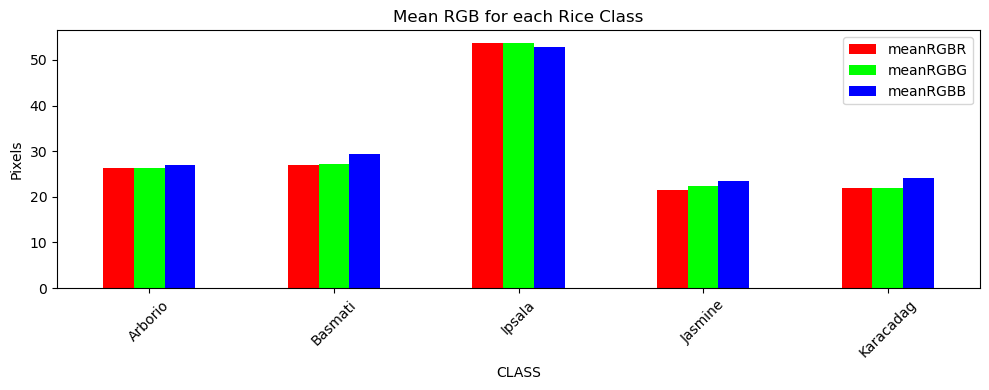

In [ ]:
# average intensity of the specific colour in the RGB for the various rice classes
mean_columns_RGB=[]
columns = df.columns
for c in columns:
    if c.startswith('meanRGB'):
        mean_columns_RGB.append(c)
    else:
        pass
mean_columns_RGB.append('CLASS')
mean_columns_RGB

class_colors = ['#FF0000', '#00FF00', '#0000FF']

plt.figure(figsize=(10, 4))
ax=plt.subplot()
df[mean_columns_RGB].groupby('CLASS').mean().plot(kind='bar', ax=ax, color=class_colors)
ax.set_title('Mean RGB for each Rice Class')
ax.set_ylabel('Pixels')
plt.xticks(rotation=45)
plt.tight_layout();

ispala has a higer colour intensity as compared to the other rice classes.

The average intensity of the three colour is almost the same in the different rice classes.

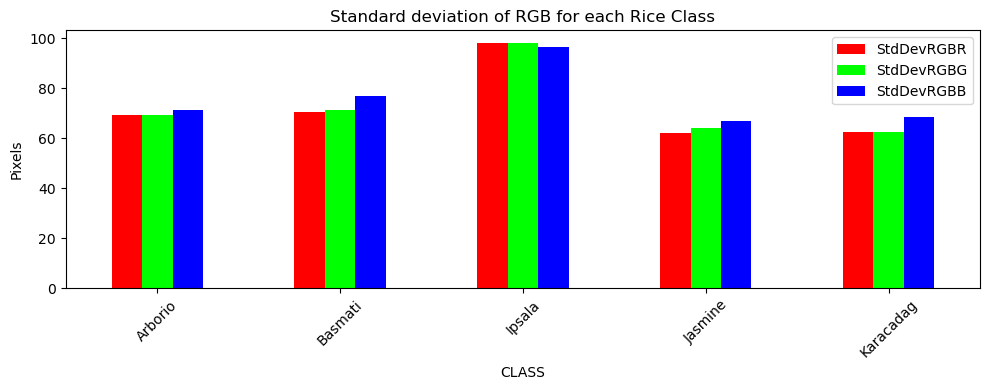

In [ ]:
# variation of the specific colour from the mean in the RGB for the various rice classes
columns_RGB=[]
for c in columns:
    if c.startswith('StdDevR'):
        columns_RGB.append(c)
    else:
        pass
columns_RGB.append('CLASS')
columns_RGB


plt.figure(figsize=(10, 4))
ax=plt.subplot()
df[columns_RGB].groupby('CLASS').mean().plot(kind='bar', ax=ax, color=class_colors)
ax.set_title('Standard deviation of RGB for each Rice Class')
ax.set_ylabel('Pixels')
plt.xticks(rotation=45)
plt.tight_layout();

There is high standard deviation (above 60) in all RGB channels for the different rice, this indicates significant color variation and contrast throughout the images.

Ipsala has a higher color variation for all RGB channels as compared to the other rice types.

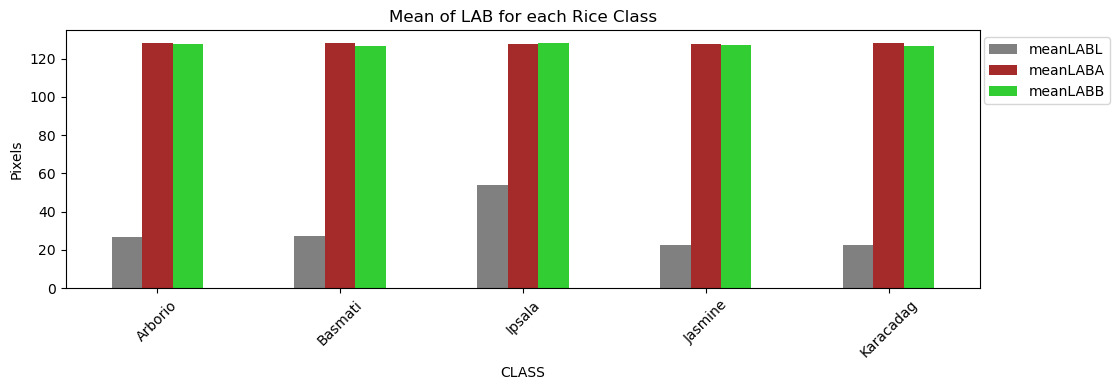

In [ ]:
columns_LAB=[]
for c in columns:
    if c.startswith('meanLAB'):
        columns_LAB.append(c)
    else:
        pass
columns_LAB.append('CLASS')
columns_LAB
channel_colors = {'meanLABL': 'gray', 'meanLABA': 'brown', 'meanLABB': 'limegreen'}

plt.figure(figsize=(10, 4))
ax=plt.subplot()
df[columns_LAB].groupby('CLASS').mean().plot(kind='bar', ax=ax, color=channel_colors)
ax.set_title('Mean of LAB for each Rice Class')
ax.set_ylabel('Pixels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1));

All classes of rice generally have have a dark color with the lighest being ipsala as indicated by the small values of the LABL which measures the lightness of color.

All rice grains have reddish hues as indicated by the positive values of the LABA which measures the color component from green to red.

All rice grains have yellowish hues as indicated by the positive values of the LABB which measures the color component from blue to yellow.

In [ ]:
df.groupby('CLASS')['ECCENTRICITY'].mean()

CLASS
Arborio      1.000000
Basmati      0.999602
Ipsala       0.999986
Jasmine      0.999886
Karacadag    1.000000
Name: ECCENTRICITY, dtype: float64

Eccentricity is a measure of how elongated an object is with a scale of 0-1 with zero being circular and 1 being elongated, all rice classes are elongated as they have a value that is one or close to one.

## IMAGE PREPROCESSING

Resizing Images

This is a fundamental preprocessing step in image recognition tasks to ensure uniformity in input dimensions, which is often required by neural networks.

We Resize all images to a uniform size (e.g., 128x128 pixels) and normalize the pixel values to the range [0, 1]:

Normalization

This involves scaling pixel values to a standard range, which helps in stabilizing the training of neural networks. In the context of image data, normalization is commonly done by scaling pixel values to a range between 0 and 1. This process ensures that each pixel value is represented as a floating-point number between 0 and 1, which is easier for the model to process and learn from consistently across different images.

Augmentation

This is a technique used to artificially expand your dataset by applying random transformations to existing images. This helps improve the generalization and robustness of your model by exposing it to a wider variety of data variations

**Resizing the Images**

In [ ]:
def load_images(dataset_path, categories, num_images=7500):
    data = []
    labels = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_images]
        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data.append(img)
            labels.append(category)
    return np.array(data), np.array(labels)

data, labels = load_images(dataset_path, categories)

target_size = (128, 128)

def preprocess_images(data, target_size):
    data_resized = [cv2.resize(img, target_size) for img in data]
    return np.array(data_resized)

data = preprocess_images(data, target_size)


print(f"Resized data shape: {data.shape}")



Resized data shape: (37500, 128, 128, 3)


**Normalizing the Images**

In [ ]:
# Normalize the image data
data = np.array(data, dtype='float32') / 255.0
# combined_data = np.array(combined_data, dtype='float32') / 255.0


**Augmenting the Images**

In [ ]:
import numpy as np
import random
import cv2

# Augmentation functions
def add_noise(image, mean=0, std=25):
    gauss = np.random.normal(mean, std, image.shape).astype('float32')
    noisy = np.clip(image + gauss, 0, 255).astype('uint8')
    return noisy

def crop_image(image, start_x, start_y, width, height):
    end_x = min(start_x + width, image.shape[1])
    end_y = min(start_y + height, image.shape[0])
    return image[start_y:end_y, start_x:end_x]

def blur_image(image, ksize):
    if ksize % 2 == 0:  # Ensure kernel size is odd
        ksize += 1
    if len(image.shape) < 3 or image.shape[0] == 0 or image.shape[1] == 0:
        raise ValueError("Input image is not a valid image")
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def augment_image(image):
    aug_images = []
    aug_images.append(add_noise(image))
    aug_images.append(crop_image(image, 10, 10, image.shape[1] - 20, image.shape[0] - 20))  # Example crop
    aug_images.append(blur_image(image, 5))
    return aug_images

def resize_image(image, size=(128, 128)):
    return cv2.resize(image, size)

# Categories
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Store augmented images and labels
augmented_data = []
augmented_labels = []

# Process and augment images
for category in categories:
    category_indices = np.where(labels == category)[0]
    num_images_to_augment = 2500

    if len(category_indices) > 0:
        images_to_augment = random.sample(list(category_indices), min(num_images_to_augment, len(category_indices)))

        for idx in images_to_augment:
            image = data[idx]
            image = resize_image(image, size=(128, 128))  # Resize image to 128x128
            augmented_images = augment_image(image)
            for aug_image in augmented_images:
                aug_image = resize_image(aug_image, size=(128, 128))  # Ensure all augmented images are 128x128
                augmented_data.append(aug_image)
                augmented_labels.append(category)

# Convert augmented data and labels to numpy arrays
augmented_data = np.array(augmented_data, dtype='uint8')
augmented_labels = np.array(augmented_labels)

print("Augmentation completed and images stored in variables.")


Augmentation completed and images stored in variables.


In [ ]:
augmented_data.shape

(37500, 128, 128, 3)

In [ ]:
# Merge the original and augmented datasets
combined_data = np.concatenate((data, augmented_data), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

print("Original data shape:", data.shape)
print("Augmented data shape:", augmented_data.shape)
print("Combined data shape:", combined_data.shape)

Original data shape: (37500, 128, 128, 3)
Augmented data shape: (37500, 128, 128, 3)
Combined data shape: (75000, 128, 128, 3)


**Model Architecture**

Designing a model architecture for image classification involves defining the layers and configuration of a neural network.

In [ ]:

# Encode the labels
label_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_dict[label] for label in labels])
augmented_labels
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, encoded_labels, test_size=0.3, random_state=42)

# Build the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(encoded_labels))

# Build and compile the model
model = build_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\bmaruru\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

The baseline model architecture comprises a total of 7392965 parameters, with all parameters being trainable. The model's size is approximately 28.20 MB. There are no non-trainable parameters in this architecture, showing that all parameters are updated during the training process.

In [ ]:
start = datetime.datetime.now()
# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_val, y_val))
end = datetime.datetime.now()
training_duration = end - start
print(f"Training completed in: {training_duration}")

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 115s 267ms/step - accuracy: 0.8293 - loss: 0.4788 - val_accuracy: 0.9691 - val_loss: 0.0952
Epoch 2/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 104s 254ms/step - accuracy: 0.9597 - loss: 0.1197 - val_accuracy: 0.9722 - val_loss: 0.0753
Epoch 3/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 100s 243ms/step - accuracy: 0.9700 - loss: 0.0965 - val_accuracy: 0.9840 - val_loss: 0.0459
Training completed in: 0:05:25.324155
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9848 - loss: 0.0411
Validation Loss: 0.04592728242278099
Validation Accuracy: 0.984000027179718


In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
class_report = classification_report(y_val, y_pred_classes, target_names=label_dict.keys())
print(class_report)

352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step
              precision    recall  f1-score   support

     Arborio       0.99      0.95      0.97      2294
     Basmati       0.99      0.99      0.99      2259
      Ipsala       1.00      1.00      1.00      2186
     Jasmine       0.99      0.99      0.99      2206
   Karacadag       0.95      1.00      0.97      2305

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250



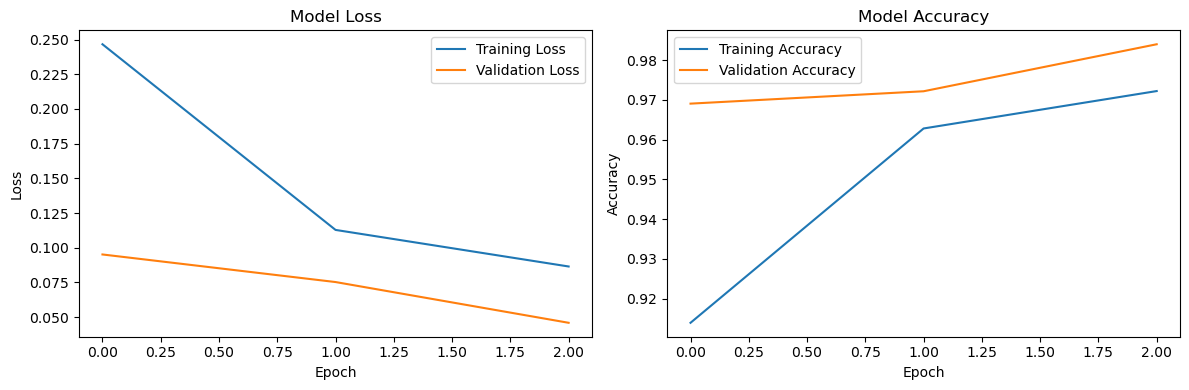

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    # Plot the loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


**Tuning the CNN baseline model**

In [ ]:
# Encode the labels
label_dict = {label: idx for idx, label in enumerate(np.unique(combined_labels))}
encoded_labels = np.array([label_dict[label] for label in combined_labels])
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_data, encoded_labels, test_size=0.3, random_state=42)

# Build the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),BatchNormalization(),MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),BatchNormalization(),MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),BatchNormalization(),MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(encoded_labels))

# Build and compile the model
model = build_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,181 (12.61 MB)

 Trainable params: 3,305,733 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
start = datetime.datetime.now()
# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_val, y_val))
end = datetime.datetime.now()
training_duration = end - start
print(f"Training completed in: {training_duration}")

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/3
821/821 ━━━━━━━━━━━━━━━━━━━━ 642s 778ms/step - accuracy: 0.3841 - loss: 3.9994 - val_accuracy: 0.5493 - val_loss: 0.9879
Epoch 2/3
821/821 ━━━━━━━━━━━━━━━━━━━━ 643s 783ms/step - accuracy: 0.5101 - loss: 1.0132 - val_accuracy: 0.3789 - val_loss: 3.4927
Epoch 3/3
821/821 ━━━━━━━━━━━━━━━━━━━━ 639s 778ms/step - accuracy: 0.5131 - loss: 1.0105 - val_accuracy: 0.5030 - val_loss: 1.0758
Training completed in: 0:32:11.861354
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.5046 - loss: 1.0740
Validation Loss: 1.075829029083252
Validation Accuracy: 0.5029777884483337


In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
class_report = classification_report(y_val, y_pred_classes, target_names=label_dict.keys())
print(class_report)

704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step
              precision    recall  f1-score   support

     Arborio       0.30      0.85      0.44      4522
     Basmati       0.61      0.51      0.55      4448
      Ipsala       1.00      0.48      0.65      4509
     Jasmine       0.56      0.19      0.29      4442
   Karacadag       0.93      0.48      0.64      4579

    accuracy                           0.50     22500
   macro avg       0.68      0.50      0.51     22500
weighted avg       0.68      0.50      0.51     22500



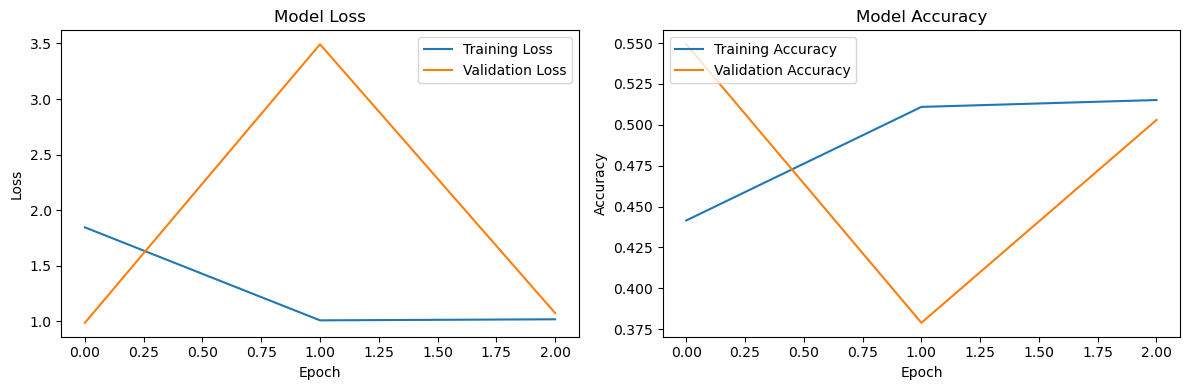

In [ ]:
def plot_loss_and_accuracy(history):
    # Plot the loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)

**Complex Architecture**

We build a more complex CNN architecture, by incorporate additional layers and techniques such as more convolutional layers, residual connections (using skip connections), and deeper layers.

**Pre-trained ResNet50V2 Architecture**

The purpose of usinga pre-trained model like ResNet50V2 was to significantly boost the performance of our image classification task,We leveraged transfer learning, which involves fine-tuning a pre-trained model on your specific dataset.

In [ ]:
from keras.applications import ResNet50V2
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

# Define input shape and number of classes
input_shape = (128, 128, 3)  # Example input shape
num_classes = 5  # Example number of classes

# Define the input layer
input_layer = Input(shape=input_shape)

# Load the ResNet50V2 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()




Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 32, 32, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 32, 32, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 34, 34, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,616,453 (93.90 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
from keras.callbacks import EarlyStopping
import datetime
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, patience=2):
    """
    Train the model, evaluate on validation set, and plot training history.
    """
    start = datetime.datetime.now()

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping])

    # Duration
    end = datetime.datetime.now()
    print(f"Training completed in: {end - start}")

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy:", val_accuracy)

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    return history


history = train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, patience=2)


Epoch 1/10
407/821 ━━━━━━━━━━━━━━━━━━━━ 5:37 814ms/step - accuracy: 0.5456 - loss: 2.0739

**Fine Tuning the model**

We fine-tuned the entire model by unfreezing some of the layers in the base model and continuing training with a very low learning rate.

In [ ]:
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history = train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, patience=2)

# Plot the fine-tuning training history
plot_training_history(history_fine)

Summary

We have adding custom layers on top of the pre-trained model and training them while keeping the base model's layers frozen. After the initial training, it unfreezes some layers of the base model for fine-tuning with a lower learning rate, allowing the model to adjust the pre-trained weights to the specific dataset. Early stopping is used to prevent overfitting, and the training history is plotted to visualize the training process.